In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np# 日本語フォントを指定（macの例）
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'IPAexGothic', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# プレイバイプレイ
df23_24 = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_23-24シーズン.csv")
df24_25 = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_24-25シーズン.csv")

use = pd.concat([df23_24, df24_25], ignore_index=True)

use['is_OT']   = use['ピリオド'].between(5, 6, inclusive='both')
use["MINUTES"] = np.where(use["is_OT"], 5, 10)

# 型を整える＆不要行除外
use['ピリオド'] = pd.to_numeric(use['ピリオド'], errors='coerce')
use['チームID'] = pd.to_numeric(use['チームID'], errors='coerce')
use = use.dropna(subset=['試合ID','ピリオド','チームID','アクション1'])
use = use[use['チームID'] != 0]

paint_labels = {"underbasket", "inthepaint"}
twopoint_labels = {"underbasket","inthepaint","insiderightwing", "insideright", "insidecenter", "insideleft", "insideleftwing"}
threepoint_labels = {"outsiderightwing", "outsideright","outsidecenter","outsideleft","outsideleftwing", "backcourt"}

# 安全な相関関数
def safe_corr(df, a, b):
    sub = df[[a,b]].dropna()
    if len(sub) < 2: return np.nan
    if sub[a].nunique() < 2 or sub[b].nunique() < 2: return np.nan
    return round(float(sub[a].corr(sub[b])), 3)

In [3]:


def summarize(df):
    agg = df.groupby(['試合ID','ピリオド','チームID'])['アクション1'].agg(
        threeFGA_sum=lambda s: s.isin([1, 2]).sum(),
        twoFGA_sum=lambda s: s.isin([3, 4, 5, 6]).sum(),
        twoFGM_sum=lambda s: s.isin([3, 4]).sum(),
        outsidepaint_twoFGM_sum=lambda s: s.isin([3]).sum(),
        insidepaint_twoFGM_sum=lambda s: s.isin([4]).sum(),
        outsidepaint_twoFGA_sum=lambda s: s.isin([3, 5]).sum(),
        insidepaint_twoFGA_sum=lambda s: s.isin([4, 6]).sum(),
    ).reset_index()

    # OT判定（5Q以上をOT扱い）
    agg['is_OT'] = agg['ピリオド'] >= 5

    # 全体 2FG% = 2FGM / 2FGA
    agg['twoFG_pct'] = np.divide(
        agg['twoFGM_sum'], agg['twoFGA_sum'],
        out=np.zeros_like(agg['twoFGM_sum'], dtype=float),
        where=agg['twoFGA_sum'] > 0
    )

    # 内ペイント 2FG% = inside FGM / inside FGA   ← 分母を修正
    agg['insidepaint_twoFG_pct'] = np.divide(
        agg['insidepaint_twoFGM_sum'], agg['insidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['insidepaint_twoFGM_sum'], dtype=float),
        where=agg['insidepaint_twoFGA_sum'] > 0
    )

    # （任意）外ペイント 2FG%
    agg['outsidepaint_twoFG_pct'] = np.divide(
        agg['outsidepaint_twoFGM_sum'], agg['outsidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['outsidepaint_twoFGM_sum'], dtype=float),
        where=agg['outsidepaint_twoFGA_sum'] > 0
    )

    return agg

action_counts = summarize(use)
action_counts_alphas = action_counts[action_counts['チームID'] == 745].copy()
action_counts_OT = action_counts[action_counts['is_OT'] == True].copy()
action_counts_not_OT = action_counts[action_counts['is_OT'] == False].copy()


print('twoFG_pct',safe_corr(action_counts, 'threeFGA_sum', 'twoFG_pct'))
print('insidepaint_twoFG_pct:',safe_corr(action_counts, 'threeFGA_sum', 'insidepaint_twoFG_pct'))

twoFG_pct -0.019
insidepaint_twoFG_pct: -0.025


In [4]:
action_counts

,試合ID,ピリオド,チームID,threeFGA_sum,twoFGA_sum,twoFGM_sum,outsidepaint_twoFGM_sum,insidepaint_twoFGM_sum,outsidepaint_twoFGA_sum,insidepaint_twoFGA_sum,is_OT,twoFG_pct,insidepaint_twoFG_pct,outsidepaint_twoFG_pct
0,501291,1,693,10,11,4,1,3,2,9,False,0.363636,0.333333,0.500000
1,501291,1,702,9,10,4,0,4,2,8,False,0.400000,0.500000,0.000000
2,501291,2,693,6,9,4,0,4,2,7,False,0.444444,0.571429,0.000000
3,501291,2,702,8,8,3,1,2,2,6,False,0.375000,0.333333,0.500000
4,501291,3,693,3,7,2,0,2,1,6,False,0.285714,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19089,503926,2,2486,15,5,3,0,3,1,4,False,0.600000,0.750000,0.000000
19090,503926,3,696,5,17,9,2,7,3,14,False,0.529412,0.500000,0.666667
19091,503926,3,2486,5,9,4,0,4,0,9,False,0.444444,0.444444,0.000000
19092,503926,4,696,5,7,3,0,3,2,5,False,0.428571,0.600000,0.000000


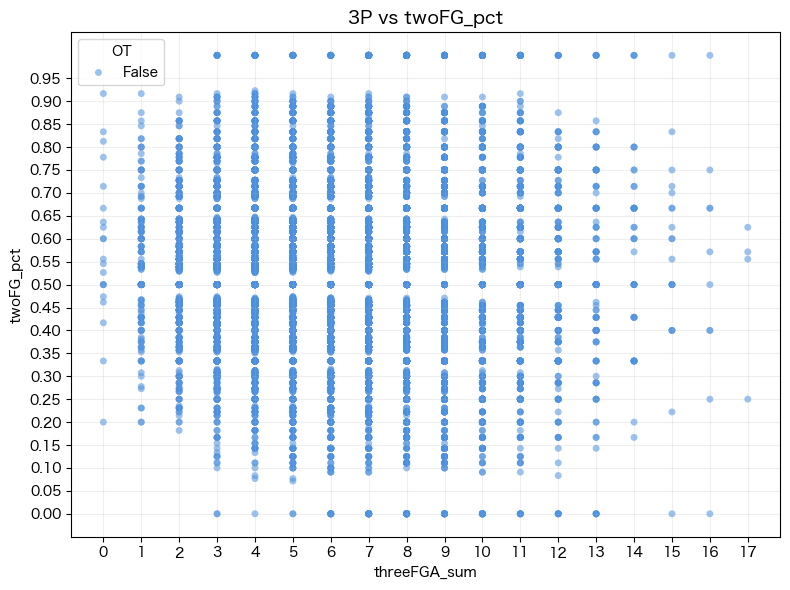

21 6.530877976190476               threeFGA_sum  twoFG_pct
threeFGA_sum      1.000000  -0.018536
twoFG_pct        -0.018536   1.000000


In [5]:
#使ってない
df = action_counts_not_OT

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data = action_counts_not_OT,
    x="threeFGA_sum",
    y="twoFG_pct",
    hue="is_OT",
    palette={False: "#4A90E2", True: "#F5A623"},  # カラー固定で視認性UP
    s=25,         # 点をさらに小さく
    alpha=0.55,   # やや透過
    linewidth=0
)

plt.title("3P vs twoFG_pct", fontsize=13)
plt.xlabel("threeFGA_sum")
plt.ylabel("twoFG_pct")
plt.xticks(np.arange(0, 18, step=1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.legend(title="OT")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print(
# 3Pゼロピリオドの数
(df['threeFGA_sum'] == 0).sum(),

# ピリオドごとの平均3P試投数
df['threeFGA_sum'].mean(),

# 相関係数
df[['threeFGA_sum', 'twoFG_pct']].corr()
)

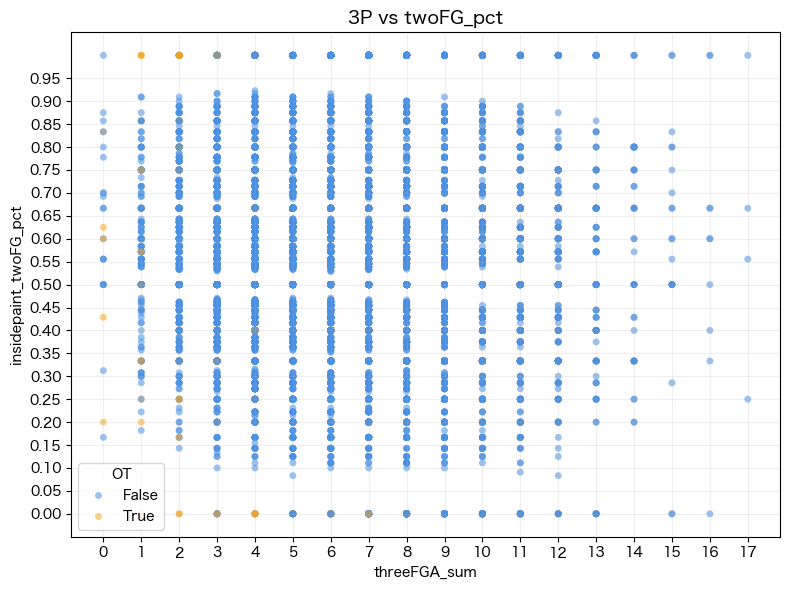

In [6]:
#使ってない
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data = action_counts,
    x="threeFGA_sum",
    y="insidepaint_twoFG_pct",
    hue="is_OT",
    palette={False: "#4A90E2", True: "#F5A623"},  # カラー固定で視認性UP
    s=25,         # 点をさらに小さく
    alpha=0.55,   # やや透過
    linewidth=0
)

plt.title("3P vs twoFG_pct", fontsize=13)
plt.xlabel("threeFGA_sum")
plt.ylabel("insidepaint_twoFG_pct")
plt.xticks(np.arange(0, 18, step=1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.legend(title="OT")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
def summarize_by_team(df):
    agg = df.groupby(['チームID','試合ID'])['アクション1'].agg(
        threeFGA_sum=lambda s: s.isin([1, 2]).sum(),
        twoFGA_sum=lambda s: s.isin([3, 4, 5, 6]).sum(),
        threeFGM_sum=lambda s: s.isin([1]).sum(),
        twoFGM_sum=lambda s: s.isin([3, 4]).sum(),
        outsidepaint_twoFGM_sum=lambda s: s.isin([3]).sum(),
        insidepaint_twoFGM_sum=lambda s: s.isin([4]).sum(),
        outsidepaint_twoFGA_sum=lambda s: s.isin([3, 5]).sum(),
        insidepaint_twoFGA_sum=lambda s: s.isin([4, 6]).sum(),
    ).reset_index()

    game_max_period = (
        df.groupby('試合ID')['ピリオド'].max()
        .rename('max_period')
    )
    game_minutes = (
        40 + np.maximum(game_max_period - 4, 0) * 5
    ).rename('game_minutes')

    agg = agg.merge(game_minutes, on='試合ID', how='left')

    agg['threeFGA_per_min'] = agg['threeFGA_sum'] / agg['game_minutes']
    agg['twoFGA_per_min']   = agg['twoFGA_sum']   / agg['game_minutes']
    agg['threeFGM_per_min'] = agg['threeFGM_sum'] / agg['game_minutes']
    agg['twoFGM_per_min']   = agg['twoFGM_sum']   / agg['game_minutes']

    # 全体 2FG% = 2FGM / 2FGA
    agg['twoFG_pct'] = np.divide(
        agg['twoFGM_sum'], agg['twoFGA_sum'],
        out=np.zeros_like(agg['twoFGM_sum'], dtype=float),
        where=agg['twoFGA_sum'] > 0
    )

    # 内ペイント 2FG% = inside FGM / inside FGA   ← 分母を修正
    agg['insidepaint_twoFG_pct'] = np.divide(
        agg['insidepaint_twoFGM_sum'], agg['insidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['insidepaint_twoFGM_sum'], dtype=float),
        where=agg['insidepaint_twoFGA_sum'] > 0
    )

    # （任意）外ペイント 2FG%
    agg['outsidepaint_twoFG_pct'] = np.divide(
        agg['outsidepaint_twoFGM_sum'], agg['outsidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['outsidepaint_twoFGM_sum'], dtype=float),
        where=agg['outsidepaint_twoFGA_sum'] > 0
    )

    team_summary = (
        agg.groupby('チームID', as_index=False).agg({
            'threeFGA_sum': 'sum',
            'twoFGA_sum': 'sum',
            'twoFGM_sum': 'sum',
            'outsidepaint_twoFGM_sum': 'sum',
            'insidepaint_twoFGM_sum': 'sum',
            'outsidepaint_twoFGA_sum': 'sum',
            'insidepaint_twoFGA_sum': 'sum',
            'game_minutes': 'sum',  # 全試合分を合計
            'threeFGA_per_min': 'mean',
            'twoFGA_per_min': 'mean',
            'threeFGM_per_min': 'mean',
            'twoFGM_per_min': 'mean',
            'twoFG_pct': 'mean',
            'insidepaint_twoFG_pct': 'mean',
            'outsidepaint_twoFG_pct': 'mean'
        })
    )

    return team_summary

action_counts_by_team = summarize_by_team(use)


,チームID,threeFGA_sum,twoFGA_sum,twoFGM_sum,outsidepaint_twoFGM_sum,insidepaint_twoFGM_sum,outsidepaint_twoFGA_sum,insidepaint_twoFGA_sum,game_minutes,threeFGA_per_min,twoFGA_per_min,threeFGM_per_min,twoFGM_per_min,twoFG_pct,insidepaint_twoFG_pct,outsidepaint_twoFG_pct
0,692,2956,5085,2500,556,1944,1386,3699,4830,0.612153,1.052481,0.193907,0.517366,0.490391,0.524374,0.396177
1,693,3441,4316,2055,286,1769,894,3422,4835,0.711546,0.892810,0.232653,0.425009,0.475125,0.516554,0.316139
2,694,3213,4785,2427,338,2089,931,3854,4850,0.662157,0.987310,0.209565,0.500764,0.508358,0.543305,0.357640
3,695,1517,2238,1088,221,867,571,1667,2410,0.629954,0.927731,0.204907,0.451574,0.485950,0.521077,0.383154
4,696,2922,5385,2839,371,2468,1046,4339,5110,0.571479,1.053718,0.173250,0.555818,0.525337,0.568010,0.354580
5,697,3974,4705,2629,198,2431,514,4191,5070,0.783254,0.928563,0.276927,0.519158,0.559700,0.580588,0.387383
6,698,3222,5107,2763,209,2554,603,4504,5075,0.634361,1.006640,0.209630,0.544784,0.540946,0.566121,0.344920
7,699,3118,4445,2430,295,2135,784,3661,4855,0.642569,0.914917,0.215440,0.500495,0.548581,0.585887,0.362581
8,700,2889,4939,2645,322,2323,884,4055,4825,0.598495,1.023773,0.193796,0.548426,0.536630,0.574429,0.367314
9,701,3726,5450,2828,339,2489,900,4550,5560,0.670385,0.980077,0.224071,0.508812,0.518767,0.546714,0.371712


In [14]:
print('threeFGA_per_minと2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGA_per_min', 'twoFG_pct'))
print('threeFGA_per_minとペイント内2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGA_per_min', 'insidepaint_twoFG_pct'))
print('threeFGA_per_minとペイント外2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGA_per_min', 'outsidepaint_twoFG_pct'))
print('threeFGM_per_minと2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGM_per_min', 'twoFG_pct'))
print('threeFGM_per_minとペイント内2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGM_per_min', 'insidepaint_twoFG_pct'))
print('threeFGM_per_minとペイント外2FG%の相関関係:',safe_corr(action_counts_by_team, 'threeFGM_per_min', 'outsidepaint_twoFG_pct'))

threeFGA_per_minと2FG%の相関関係: 0.202
threeFGA_per_minとペイント内2FG%の相関関係: 0.16
threeFGA_per_minとペイント外2FG%の相関関係: -0.03
threeFGM_per_minと2FG%の相関関係: 0.343
threeFGM_per_minとペイント内2FG%の相関関係: 0.281
threeFGM_per_minとペイント外2FG%の相関関係: 0.066


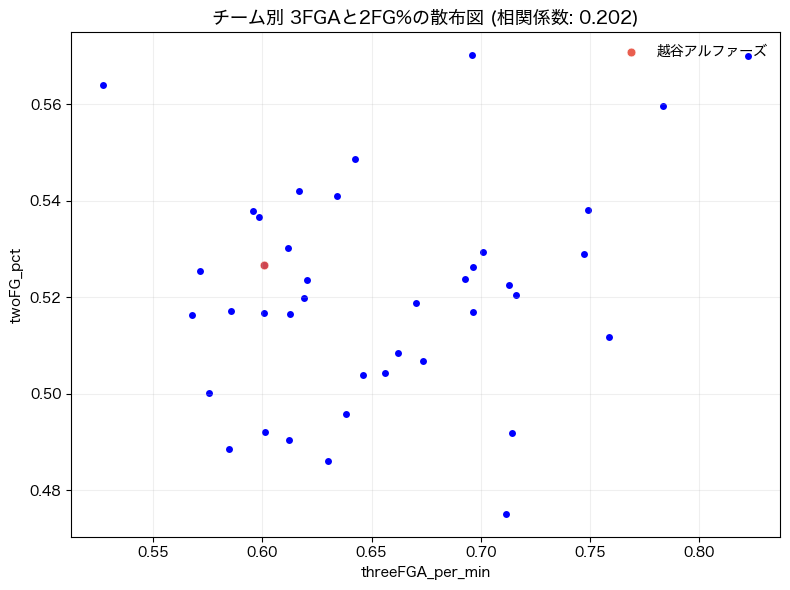

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team,
    x="threeFGA_per_min",
    y="twoFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

# 越谷アルファーズだけ別レイヤーで強調表示
sns.scatterplot(
    data=action_counts_by_team[action_counts_by_team["チーム名"]=="越谷アルファーズ"],
    x="threeFGA_per_min",
    y="twoFG_pct",
    color="#E74C3C",  # 赤系
    label="越谷アルファーズ",
    s=40,
    alpha=0.9,
    linewidth=0.5
)

corr_value = safe_corr(action_counts_by_team, 'threeFGA_per_min', 'twoFG_pct')
plt.title(f"チーム別 3FGAと2FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("threeFGA_per_min")
plt.ylabel("twoFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
#越谷アルファーズ　試合ごとの3FGAと2FG%を回帰する
def summarize_by_team_transition(df):
    agg = df.groupby(['試合ID','チームID'])['アクション1'].agg(
        threeFGA_sum=lambda s: s.isin([1, 2]).sum(),
        threeFGM_sum=lambda s: s.isin([1]).sum(),
        twoFGA_sum=lambda s: s.isin([3, 4, 5, 6]).sum(),
        twoFGM_sum=lambda s: s.isin([3, 4]).sum(),
        outsidepaint_twoFGM_sum=lambda s: s.isin([3]).sum(),
        insidepaint_twoFGM_sum=lambda s: s.isin([4]).sum(),
        outsidepaint_twoFGA_sum=lambda s: s.isin([3, 5]).sum(),
        insidepaint_twoFGA_sum=lambda s: s.isin([4, 6]).sum(),
    ).reset_index()

    # 全体 3FG% = 3FGM / 3FGA
    agg['threeFG_pct'] = np.divide(
        agg['threeFGM_sum'], agg['threeFGA_sum'],
        out=np.zeros_like(agg['threeFGM_sum'], dtype=float),
        where=agg['threeFGA_sum'] > 0
    )

    # 全体 2FG% = 2FGM / 2FGA
    agg['twoFG_pct'] = np.divide(
        agg['twoFGM_sum'], agg['twoFGA_sum'],
        out=np.zeros_like(agg['twoFGM_sum'], dtype=float),
        where=agg['twoFGA_sum'] > 0
    )

    # 内ペイント 2FG% = inside FGM / inside FGA   ← 分母を修正
    agg['insidepaint_twoFG_pct'] = np.divide(
        agg['insidepaint_twoFGM_sum'], agg['insidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['insidepaint_twoFGM_sum'], dtype=float),
        where=agg['insidepaint_twoFGA_sum'] > 0
    )

    # （任意）外ペイント 2FG%
    agg['outsidepaint_twoFG_pct'] = np.divide(
        agg['outsidepaint_twoFGM_sum'], agg['outsidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['outsidepaint_twoFGM_sum'], dtype=float),
        where=agg['outsidepaint_twoFGA_sum'] > 0
    )

    return agg
print(summarize_by_team_transition(use).head())
action_counts_by_team_transition = summarize_by_team_transition(use)
action_counts_by_team_transition_alphas = action_counts_by_team_transition[action_counts_by_team_transition['チームID']== 745].copy()

     試合ID  チームID  threeFGA_sum  threeFGM_sum  twoFGA_sum  twoFGM_sum  \
0  501291    693            24            10          34          13   
1  501291    702            30             5          44          20   
2  501292    693            28             9          30          16   
3  501292    702            27             7          38          26   
4  501293    692            18             6          48          27   

   outsidepaint_twoFGM_sum  insidepaint_twoFGM_sum  outsidepaint_twoFGA_sum  \
0                        1                      12                        6   
1                        3                      17                       10   
2                        4                      12                        8   
3                        5                      21                        9   
4                        2                      25                       10   

   insidepaint_twoFGA_sum  threeFG_pct  twoFG_pct  insidepaint_twoFG_pct  \
0               

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/2529761645.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


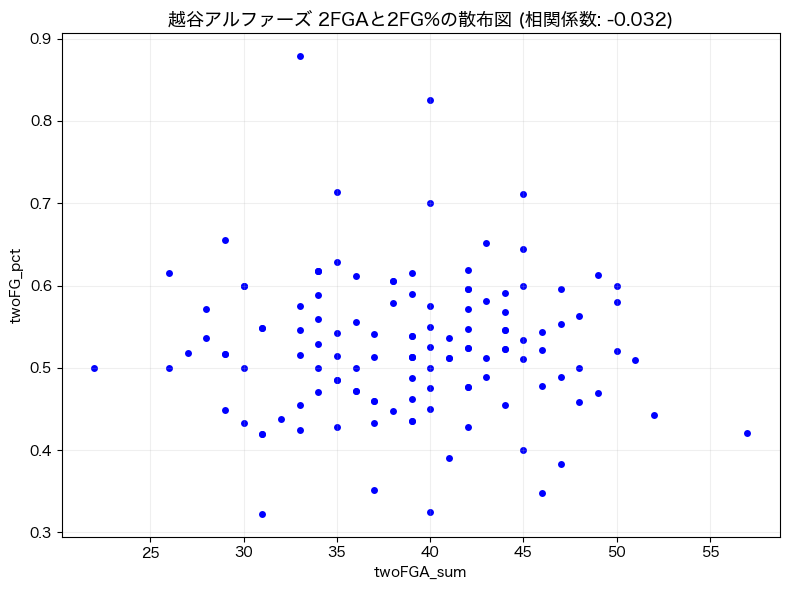

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_transition_alphas,
    x="twoFGA_sum",
    y="twoFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_transition_alphas, 'twoFGA_sum', 'twoFG_pct')
plt.title(f"越谷アルファーズ 2FGAと2FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("twoFGA_sum")
plt.ylabel("twoFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/2738888557.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


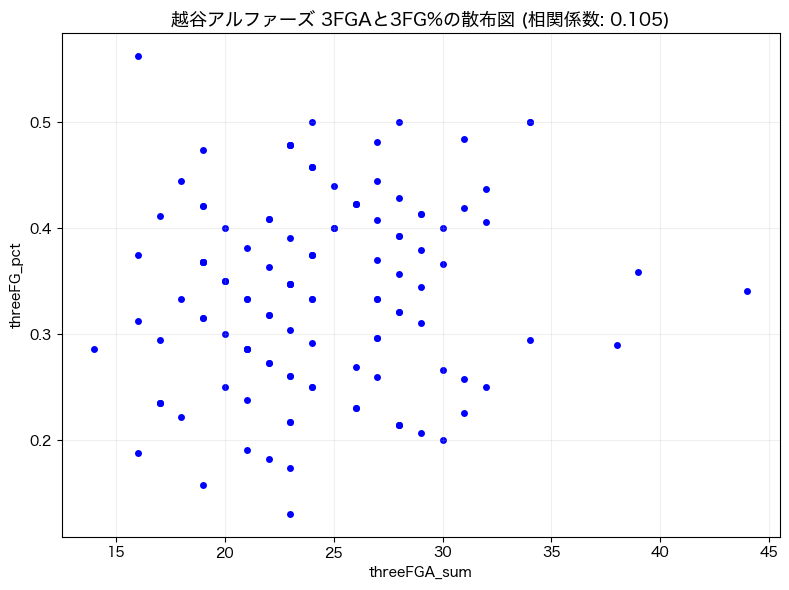

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_transition_alphas,
    x="threeFGA_sum",
    y="threeFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_transition_alphas, 'threeFGA_sum', 'threeFG_pct')
plt.title(f"越谷アルファーズ 3FGAと3FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("threeFGA_sum")
plt.ylabel("threeFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/182010452.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


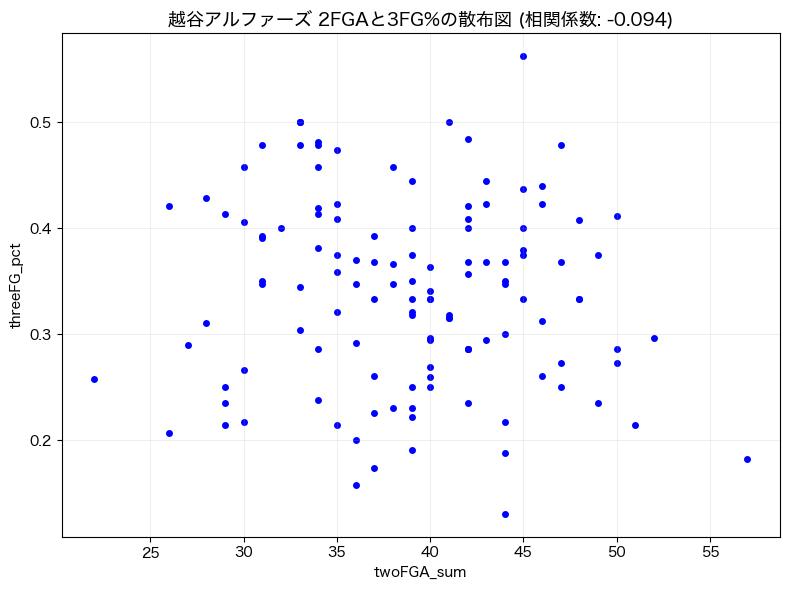

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_transition_alphas,
    x="twoFGA_sum",
    y="threeFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_transition_alphas, 'twoFGA_sum', 'threeFG_pct')
plt.title(f"越谷アルファーズ 2FGAと3FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("twoFGA_sum")
plt.ylabel("threeFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/2738888557.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


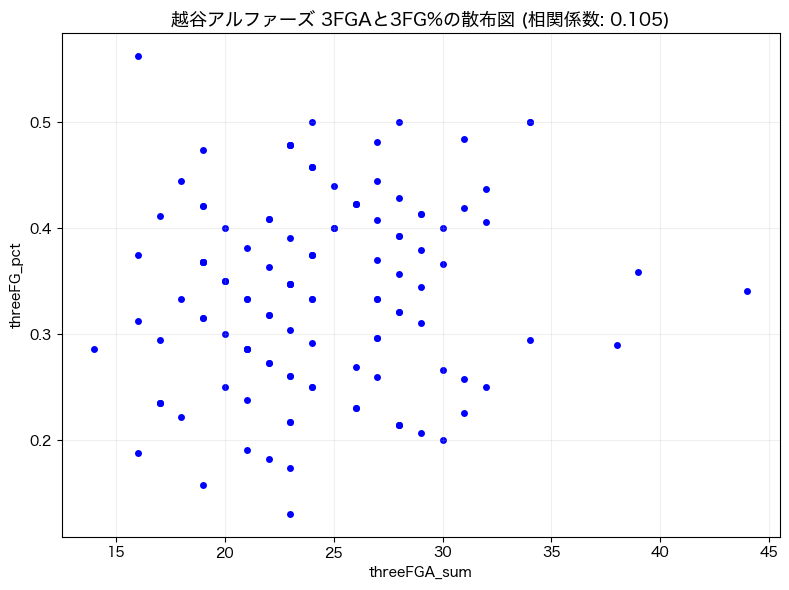

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_transition_alphas,
    x="threeFGA_sum",
    y="threeFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_transition_alphas, 'threeFGA_sum', 'threeFG_pct')
plt.title(f"越谷アルファーズ 3FGAと3FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("threeFGA_sum")
plt.ylabel("threeFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/1936676506.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


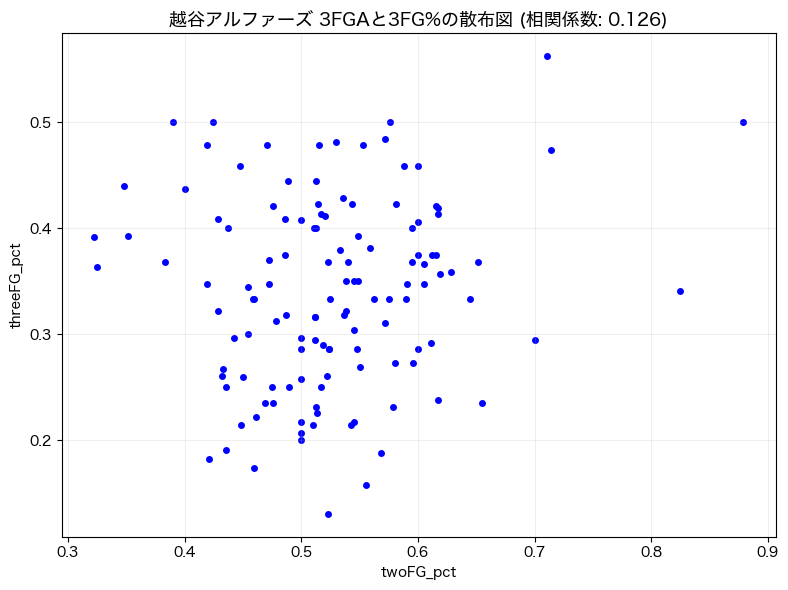

In [ ]:
plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_transition_alphas,
    x="twoFG_pct",
    y="threeFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_transition_alphas, 'twoFG_pct', 'threeFG_pct')
plt.title(f"越谷アルファーズ 3FGAと3FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("twoFG_pct")
plt.ylabel("threeFG_pct")
plt.grid(alpha=0.2)

# 凡例を右上に
plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

697:,0.004
701:,-0.158
703:,0.07
704:,0.124
706:,0.009
720:,-0.012
728:,0.214
729:,-0.067


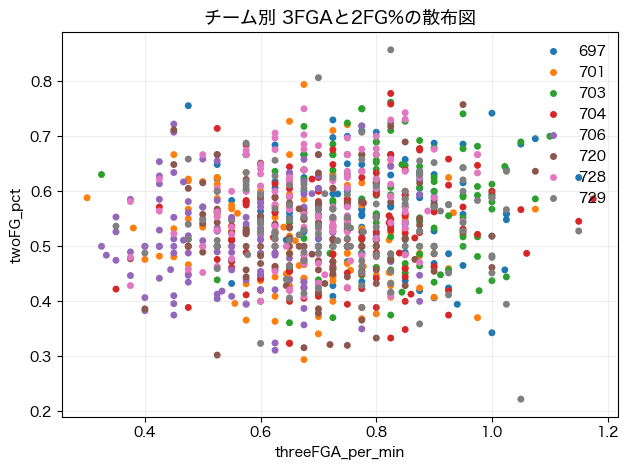

In [ ]:
def summarize_by_team_game(df):
    agg = df.groupby(['チームID','試合ID'])['アクション1'].agg(
        threeFGA_sum=lambda s: s.isin([1, 2]).sum(),
        twoFGA_sum=lambda s: s.isin([3, 4, 5, 6]).sum(),
        twoFGM_sum=lambda s: s.isin([3, 4]).sum(),
        outsidepaint_twoFGM_sum=lambda s: s.isin([3]).sum(),
        insidepaint_twoFGM_sum=lambda s: s.isin([4]).sum(),
        outsidepaint_twoFGA_sum=lambda s: s.isin([3, 5]).sum(),
        insidepaint_twoFGA_sum=lambda s: s.isin([4, 6]).sum(),
    ).reset_index()

    game_max_period = (
        df.groupby('試合ID')['ピリオド'].max()
        .rename('max_period')
    )
    game_minutes = (
        40 + np.maximum(game_max_period - 4, 0) * 5
    ).rename('game_minutes')

    agg = agg.merge(game_minutes, on='試合ID', how='left')

    agg['threeFGA_per_min'] = agg['threeFGA_sum'] / agg['game_minutes']
    agg['twoFGA_per_min']   = agg['twoFGA_sum']   / agg['game_minutes']

    # 全体 2FG% = 2FGM / 2FGA
    agg['twoFG_pct'] = np.divide(
        agg['twoFGM_sum'], agg['twoFGA_sum'],
        out=np.zeros_like(agg['twoFGM_sum'], dtype=float),
        where=agg['twoFGA_sum'] > 0
    )

    # 内ペイント 2FG% = inside FGM / inside FGA   ← 分母を修正
    agg['insidepaint_twoFG_pct'] = np.divide(
        agg['insidepaint_twoFGM_sum'], agg['insidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['insidepaint_twoFGM_sum'], dtype=float),
        where=agg['insidepaint_twoFGA_sum'] > 0
    )

    # （任意）外ペイント 2FG%
    agg['outsidepaint_twoFG_pct'] = np.divide(
        agg['outsidepaint_twoFGM_sum'], agg['outsidepaint_twoFGA_sum'],
        out=np.zeros_like(agg['outsidepaint_twoFGM_sum'], dtype=float),
        where=agg['outsidepaint_twoFGA_sum'] > 0
    )

    return agg

action_counts_by_team_game = summarize_by_team_game(use)

top_team = [697 ,701 , 703, 704, 706, 720, 728, 729]

action_counts_by_team_transition_topteam = action_counts_by_team_game[action_counts_by_team_game['チームID'].isin(top_team)].copy()


for x in top_team:
    corr_value = safe_corr(action_counts_by_team_transition_topteam[action_counts_by_team_transition_topteam['チームID']==x], 'threeFGA_per_min', 'twoFG_pct')
    print(f'{x}:,{corr_value}')

ids = sorted(action_counts_by_team_transition_topteam['チームID'].unique())

palette = dict(zip(ids, sns.color_palette('tab10', n_colors=len(ids))))

sns.scatterplot(
    data=action_counts_by_team_transition_topteam,
    x="threeFGA_per_min",
    y="twoFG_pct",
    hue="チームID",
    palette=palette,
    s=25,
    linewidth=0
)

plt.title(f"チーム別 3FGAと2FG%の散布図", fontsize=13)
plt.xlabel("threeFGA_per_min")
plt.ylabel("twoFG_pct")
plt.grid(alpha=0.2)
plt.legend(loc="upper right", fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

/var/folders/48/ttqfctzn00n26lhwkvg9g6h00000gn/T/ipykernel_48774/2895791389.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10, frameon=False)


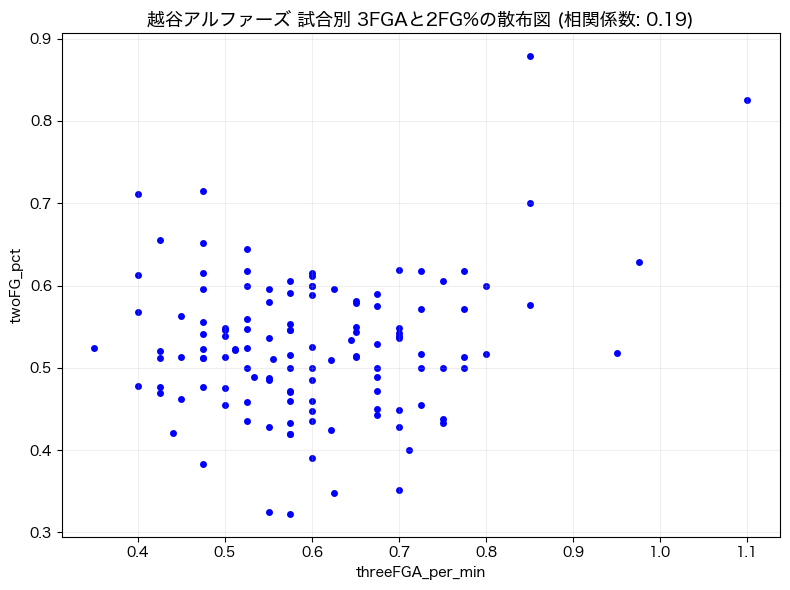

In [ ]:
action_counts_by_team_game_alphas = action_counts_by_team_game[action_counts_by_team_game['チームID']== 745].copy()

plt.figure(figsize=(8,6))

# グラフ描画：全チーム灰色でプロット
sns.scatterplot(
    data=action_counts_by_team_game_alphas,
    x="threeFGA_per_min",
    y="twoFG_pct",
    color="blue",
    s=25,
    linewidth=0
)

corr_value = safe_corr(action_counts_by_team_game_alphas, 'threeFGA_per_min', 'twoFG_pct')
plt.title(f"越谷アルファーズ 試合別 3FGAと2FG%の散布図 (相関係数: {corr_value})", fontsize=13)
plt.xlabel("threeFGA_per_min")
plt.ylabel("twoFG_pct")
plt.grid(alpha=0.2)

plt.legend(loc="upper right", fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
#点差を確認
use
box_score = pd.read_csv("/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv")
box_score

,試合ID,ピリオド区分,ホームアウェイ,チームID,チーム名,チーム名英,選手ID,背番号,選手名,スターティングフラグ,...,ディフェンスリバウンド,トータルリバウンド,ターンオーバ,アシスト,スティール,ブロックショット,被ブロックショット,ファストブレイクポイント,2Pインサイドポイント,セカンドチャンスポイント
0,501291,1,1,702,レバンガ北海道,LEVANGA HOKKAIDO,20025,1,ナナー ダニエル弾,0,...,0,0,0,0,0,0,0,0,0,0
1,501291,1,1,702,レバンガ北海道,LEVANGA HOKKAIDO,51000102,2,ドワイト・ラモス,1,...,0,1,1,0,0,0,2,0,0,0
2,501291,1,1,702,レバンガ北海道,LEVANGA HOKKAIDO,18148,4,寺園 脩斗,1,...,0,0,0,1,1,0,0,0,0,0
3,501291,1,1,702,レバンガ北海道,LEVANGA HOKKAIDO,20031,7,中野 司,0,...,0,0,1,0,0,0,0,0,0,0
4,501291,1,1,702,レバンガ北海道,LEVANGA HOKKAIDO,8509,11,桜井 良太,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280514,503926,18,2,696,富山グラウジーズ,TOYAMA GROUSES,51000137,20,上田 隼輔,1,...,0,0,2,0,0,0,0,0,0,0
280515,503926,18,2,696,富山グラウジーズ,TOYAMA GROUSES,10818,24,高橋 耕陽,0,...,1,2,1,3,0,0,0,2,4,0
280516,503926,18,2,696,富山グラウジーズ,TOYAMA GROUSES,51000136,28,野﨑 由之,0,...,2,4,0,2,2,0,0,0,2,2
280517,503926,18,2,696,富山グラウジーズ,TOYAMA GROUSES,51000297,30,アーロン・ホワイト,1,...,4,4,0,1,3,0,1,6,6,0
